In [68]:
# Import libraries
import pandas as pd
import numpy as np
import itertools

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_squared_error as mse

from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.holtwinters import ExponentialSmoothing, Holt
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARMA, ARIMA, ARIMAResults
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [5]:
O3 = pd.read_csv('data/nycO3.csv')
CO = pd.read_csv('data/nycCO.csv')
NO2 = pd.read_csv('data/nycNO2.csv')
SO2 = pd.read_csv('data/nycSO2.csv')

In [3]:
display(O3.head(), CO.head(), NO2.head(), SO2.head())

,Date,O3 AQI
0,2000-01-01,25
1,2000-01-02,38
2,2000-01-03,31
3,2000-01-04,29
4,2000-01-05,24


,Date,CO AQI
0,2000-01-01,27.0
1,2000-01-02,36.0
2,2000-01-03,38.0
3,2000-01-04,33.0
4,2000-01-05,22.0


,Date,NO2 AQI
0,2000-01-01,38
1,2000-01-02,54
2,2000-01-03,47
3,2000-01-04,52
4,2000-01-05,42


,Date,SO2 AQI
0,2000-01-01,105.0
1,2000-01-02,79.0
2,2000-01-03,99.0
3,2000-01-04,82.0
4,2000-01-05,43.0


In [31]:
df = pd.merge(O3, CO, how='inner', left_index=True, right_index=True)
df = pd.merge(df, NO2, how='inner', left_index=True, right_index=True)
df = pd.merge(df, SO2, how='inner', left_index=True, right_index=True)
df

,O3 AQI,CO AQI,NO2 AQI,SO2 AQI
Date,,,,
2000-01-01,25,27.0,38,105.0
2000-01-02,38,36.0,54,79.0
2000-01-03,31,38.0,47,99.0
2000-01-04,29,33.0,52,82.0
2000-01-05,24,22.0,42,43.0
...,...,...,...,...
2021-09-26,38,6.0,26,0.0
2021-09-27,50,3.0,22,1.0
2021-09-28,27,3.0,26,1.0


In [35]:
monthlyO3 = df['O3 AQI'].resample('M').mean()
monthlyCO = df['CO AQI'].resample('M').mean()
monthlyNO2 = df['NO2 AQI'].resample('M').mean()
monthlySO2 = df['SO2 AQI'].resample('M').mean()

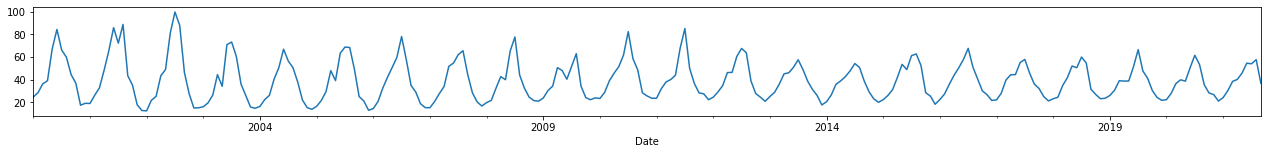

In [40]:
monthlyO3.plot(figsize=(22,2));

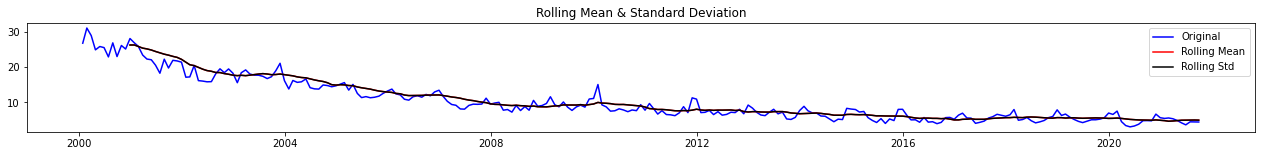

Results of Dickey-Fuller Test:
Test Statistic                  -3.660708
p-value                          0.004701
#Lags Used                      15.000000
Number of Observations Used    245.000000
Critical Value (1%)             -3.457326
Critical Value (5%)             -2.873410
Critical Value (10%)            -2.573096
dtype: float64


In [48]:
def test_stationarity(ts):
    
    #Determing rolling statistics
    rmean = ts.rolling(window=12).mean()
    rstd = ts.rolling(window=12).mean()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(22,2))
    plt.plot(ts, color='blue',label='Original')
    plt.plot(rmean, color='red', label='Rolling Mean')
    plt.plot(rstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    

test_stationarity(monthlyCO)

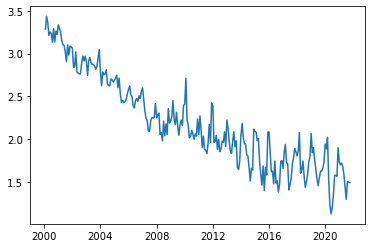

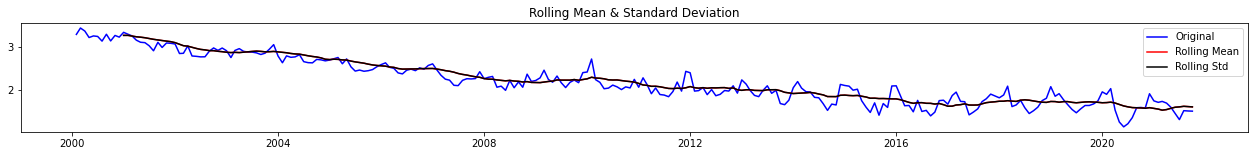

Results of Dickey-Fuller Test:
Test Statistic                  -2.432895
p-value                          0.132667
#Lags Used                      15.000000
Number of Observations Used    245.000000
Critical Value (1%)             -3.457326
Critical Value (5%)             -2.873410
Critical Value (10%)            -2.573096
dtype: float64


In [49]:
# Log
monthlyCO_log =np.log(monthlyCO)
plt.plot(monthlyCO_log)
test_stationarity(monthlyCO_log)

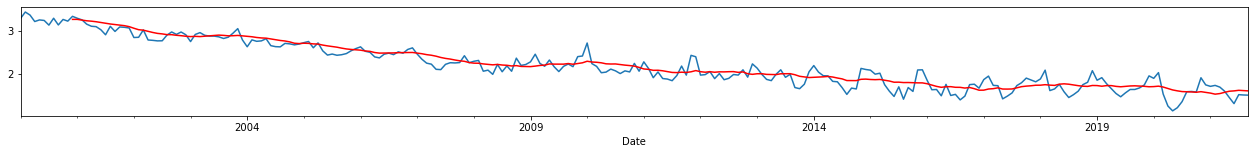

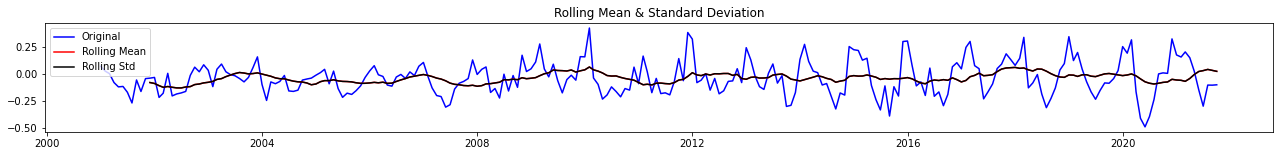

Results of Dickey-Fuller Test:
Test Statistic                  -4.206222
p-value                          0.000643
#Lags Used                      15.000000
Number of Observations Used    234.000000
Critical Value (1%)             -3.458608
Critical Value (5%)             -2.873972
Critical Value (10%)            -2.573396
dtype: float64


In [59]:
# Moving average
moving_avg = monthlyCO_log.rolling(window=12).mean()
monthlyCO_log.plot(figsize=(22,2))
moving_avg.plot(color='red')
monthlyCO_log_moving_avg_diff = monthlyCO_log - moving_avg
monthlyCO_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(monthlyCO_log_moving_avg_diff)

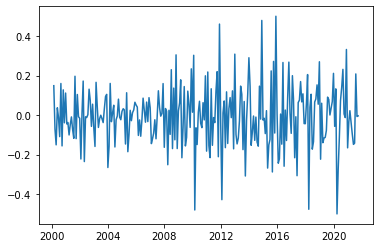

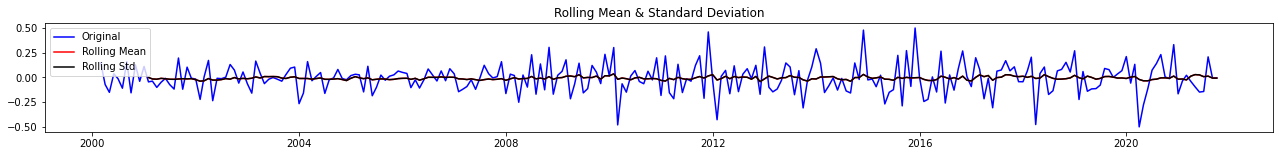

Results of Dickey-Fuller Test:
Test Statistic                  -5.066726
p-value                          0.000016
#Lags Used                      14.000000
Number of Observations Used    245.000000
Critical Value (1%)             -3.457326
Critical Value (5%)             -2.873410
Critical Value (10%)            -2.573096
dtype: float64


In [60]:
# Eliminating Trend and Seasonality
# First order differencing 
monthlyCO_log_diff = monthlyCO_log - monthlyCO_log.shift()
plt.plot(monthlyCO_log_diff)
monthlyCO_log_diff.dropna(inplace=True)
test_stationarity(monthlyCO_log_diff)

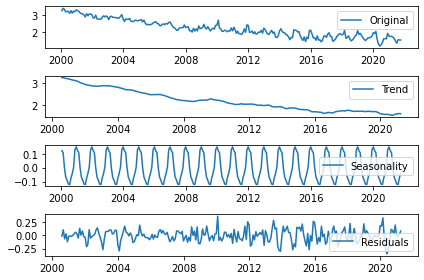

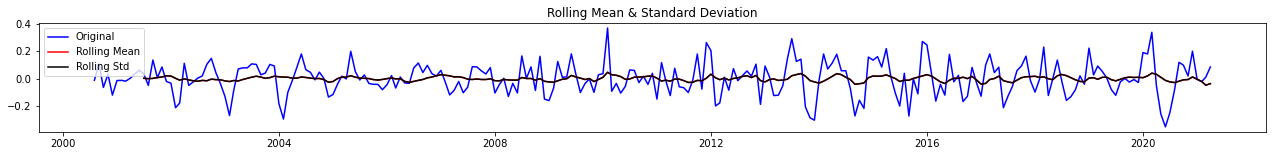

Results of Dickey-Fuller Test:
Test Statistic                -1.186295e+01
p-value                        6.778837e-22
#Lags Used                     8.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


In [62]:
# Decomposing
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(monthlyCO_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(monthlyCO_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
monthlyCO_log_decompose = residual
monthlyCO_log_decompose.dropna(inplace=True)
test_stationarity(monthlyCO_log_decompose)

In [63]:
# ACF and PACF

lag_acf = acf(monthlyCO_log_diff, nlags=20)
lag_pacf = pacf(monthlyCO_log_diff, nlags=20, method='ols')

Text(0.5, 1.0, 'Autocorrelation Function')

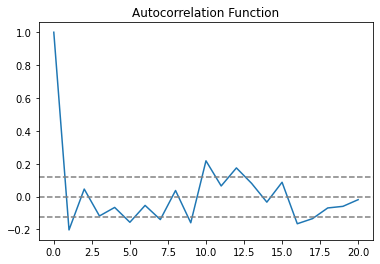

In [65]:
#Plot ACF: 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(monthlyCO_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(monthlyCO_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

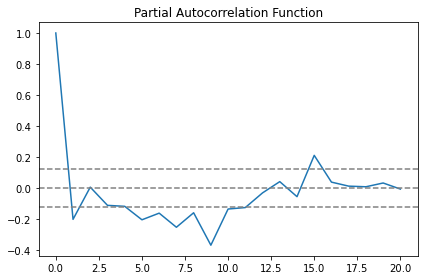

In [66]:
#Plot PACF:
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(monthlyCO_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(monthlyCO_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [69]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))

In [70]:
# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2],12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1162.2046488164751
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:815.2149755081375
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:-104.7048482820901
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:-103.48959816310824
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:-169.51464736822697
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:-234.37915320518636
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:-99.69136291353749
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:-135.26395667331423
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:833.6436569614502
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:544.0435636865254
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:-152.92419023513486
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:-154.87135811770116
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:-198.8722984113017
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:-270.48871251001736
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:-148.23183629603443
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:-156.35826125563733
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:-242.39201933276928
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:-230

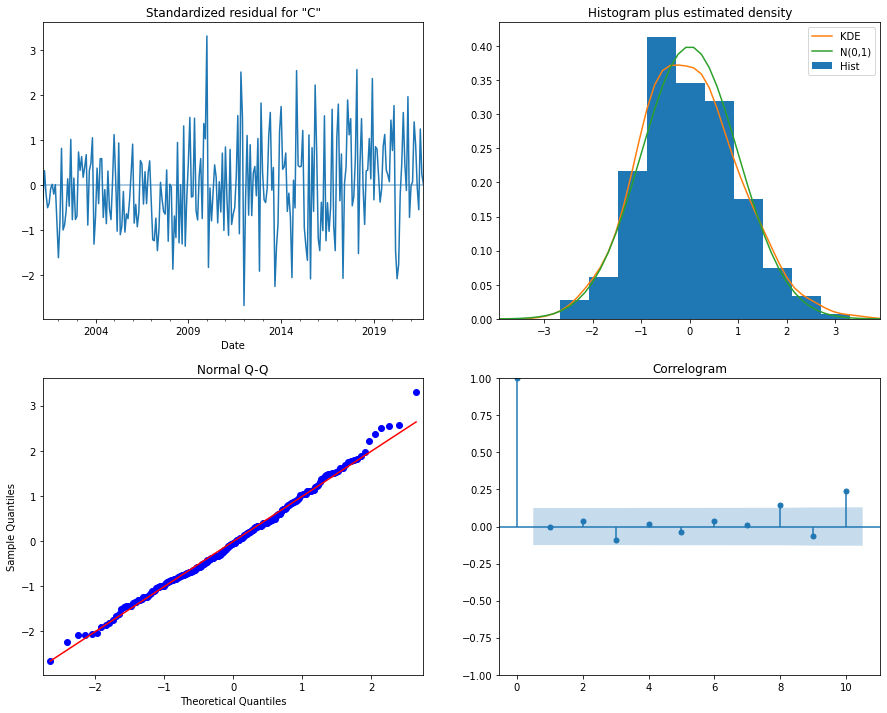

In [72]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = SARIMAX(monthlyCO_log,
                          order=param,
                          seasonal_order=param_seasonal,
                          enforce_stationarity=False,
                          enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue
        
mod = SARIMAX(monthlyCO_log,
              order=(1,0,1),
              seasonal_order=(1, 0, 1, 12),
              enforce_stationarity=False,
              enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

results.plot_diagnostics(figsize=(15, 12))
plt.show()

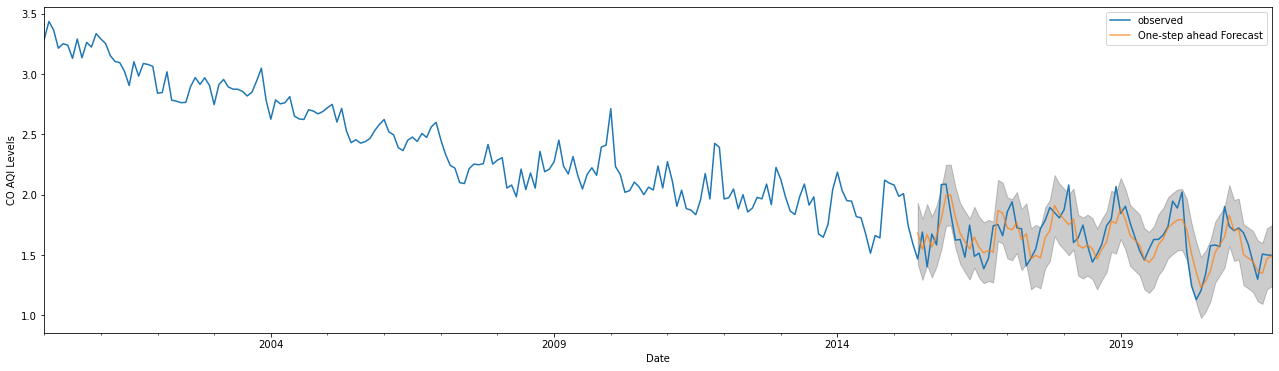

In [75]:
pred = results.get_prediction(start=pd.to_datetime('2015-06-30 00:00:00'), dynamic=False)
pred_ci = pred.conf_int()
fig = plt.figure(figsize=(22,6))
ax = monthlyCO_log['2000':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('CO AQI Levels')
plt.legend()
plt.show()

In [77]:
monthlyCO_forecasted = np.exp(pred.predicted_mean)
monthlyCO_truth = np.exp(monthlyCO_log['2015-06-30 00:00:00':])

# Compute the mean square error
mse =( (monthlyCO_forecasted - monthlyCO_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The RMSE of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of our forecasts is 0.66
The RMSE of our forecasts is 0.81


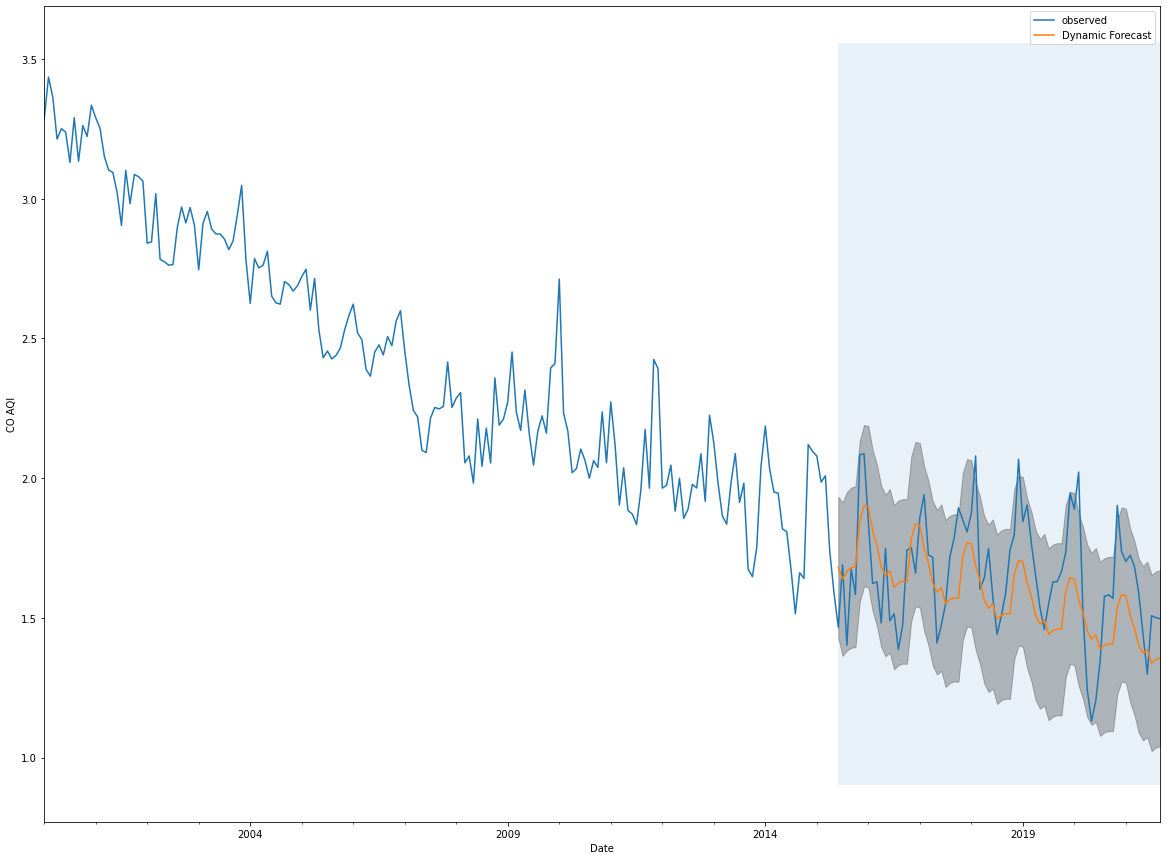

In [79]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('2015-06-30 00:00:00'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

ax = monthlyCO_log['2000':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2015-06-30 00:00:00'), monthlyCO_log.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('CO AQI')

plt.legend()
plt.show()

In [81]:
# Extract the predicted and true values of our time series
monthlyCO_forecasted = np.exp(pred_dynamic.predicted_mean)
monthlyCO_truth = np.exp(monthlyCO_log['1998-01-01':])

# Compute the mean square error
mse = ((monthlyCO_forecasted - monthlyCO_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The RMSE of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of our forecasts is 0.99
The RMSE of our forecasts is 1.0


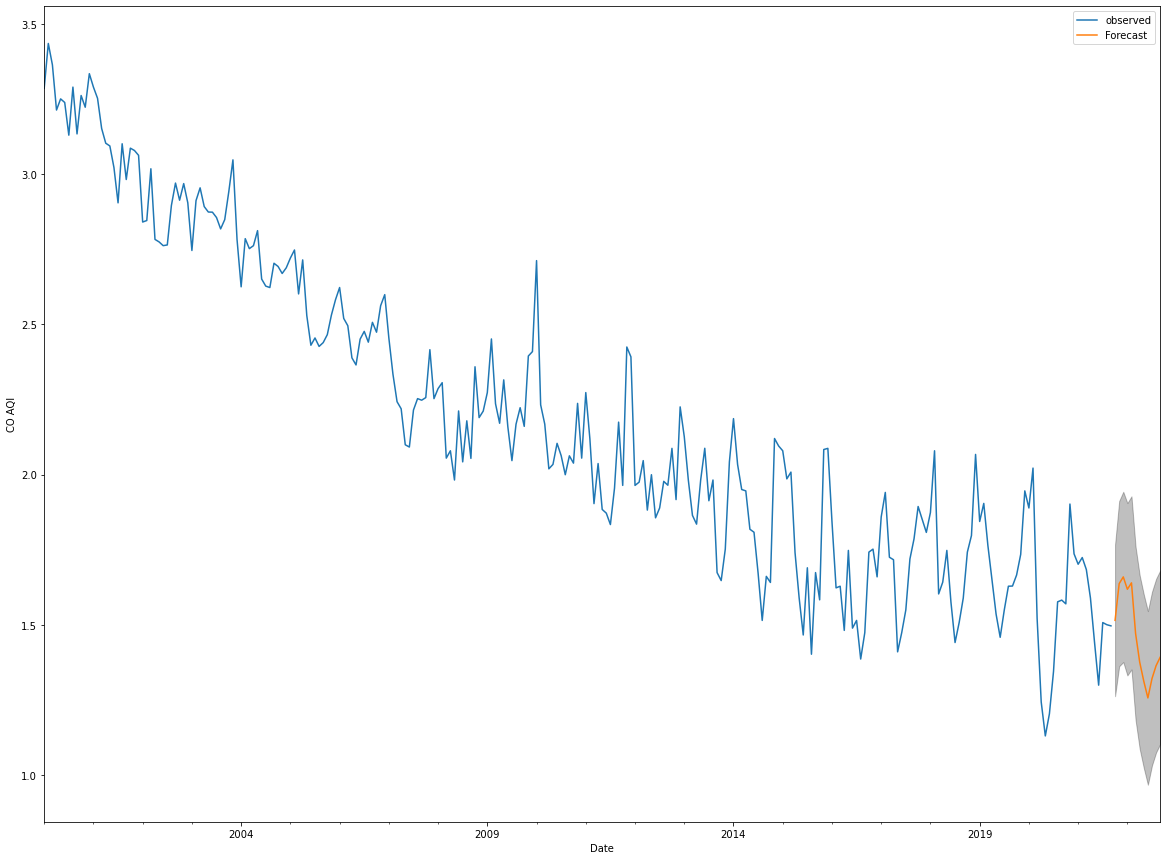

2021-10-31    4.549693
2021-11-30    5.140800
2021-12-31    5.257280
2022-01-31    5.045414
2022-02-28    5.154320
2022-03-31    4.355444
2022-04-30    3.959786
2022-05-31    3.715071
2022-06-30    3.514237
2022-07-31    3.748146
2022-08-31    3.913002
2022-09-30    4.024283
Freq: M, Name: predicted_mean, dtype: float64

In [82]:
# Get forecast 500 steps ahead in future
pred_uc = results.get_forecast(steps=12)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

ax = monthlyCO_log.plot(label='observed', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('CO AQI')

plt.legend()
plt.show()


np.exp(pred_uc.predicted_mean)

In [ ]:
# Change date columns to datetime and set as index for time series

dflist = [O3, CO, NO2, SO2]

for df in dflist:
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index(['Date'], inplace=True)
    print(df.index.dtype)

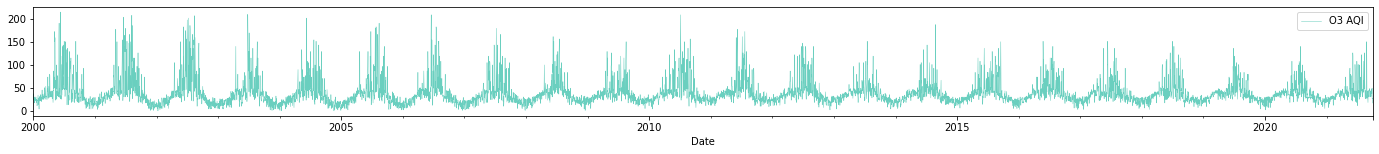

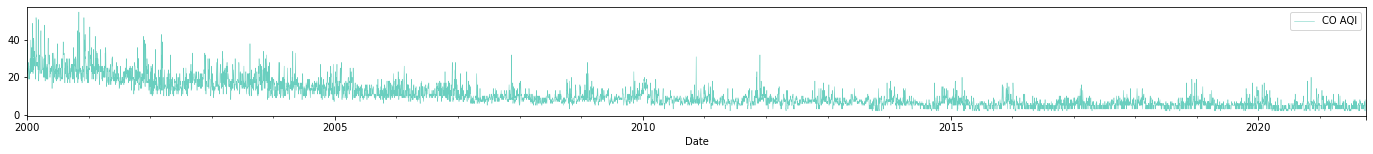

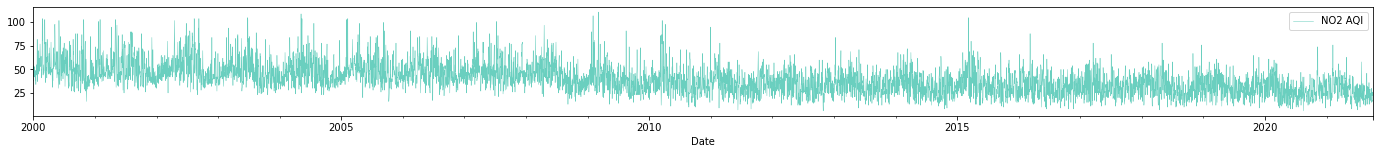

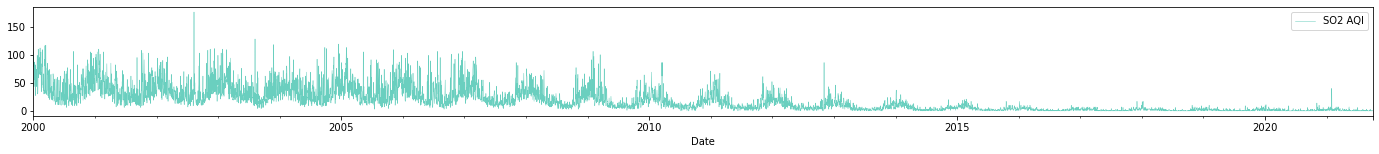

In [42]:
for df in dflist:
    df.plot(figsize=(24,2), linewidth=.5, color='#6acfbf');

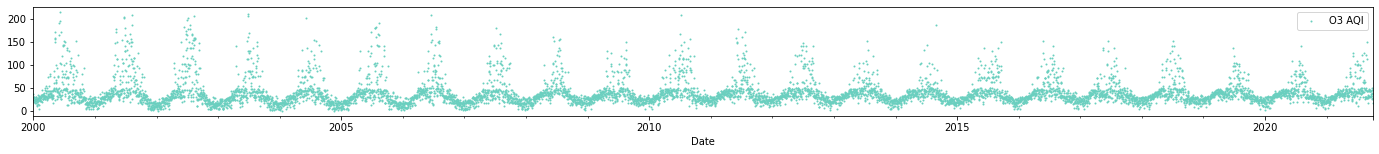

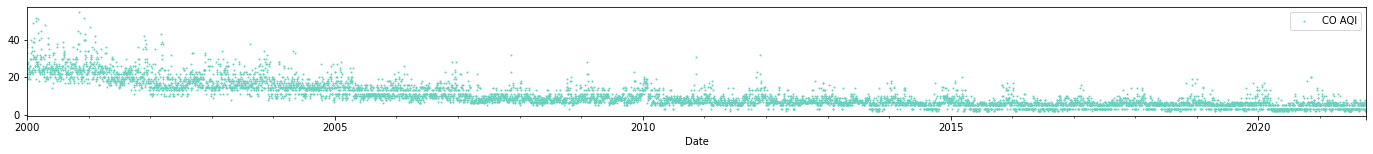

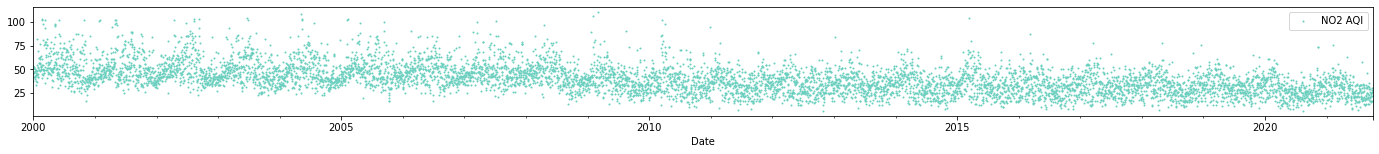

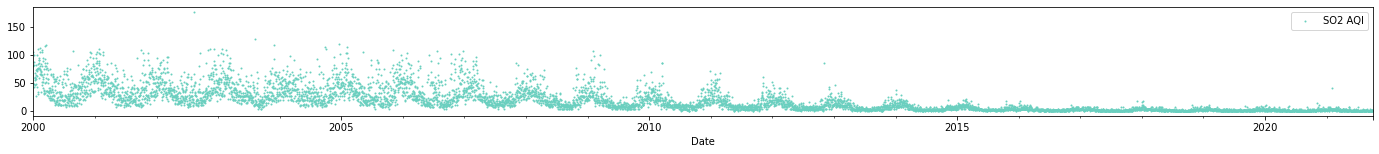

In [46]:
for df in dflist:
    df.plot(figsize=(24,2), style='.', ms=2, color='#6acfbf');

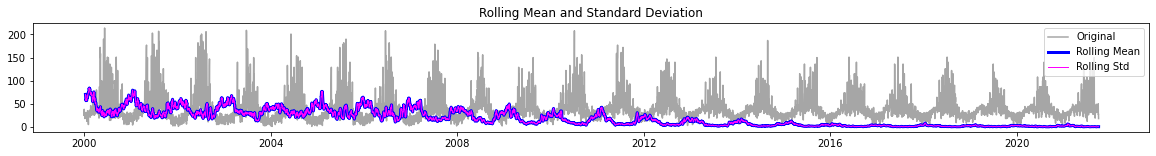

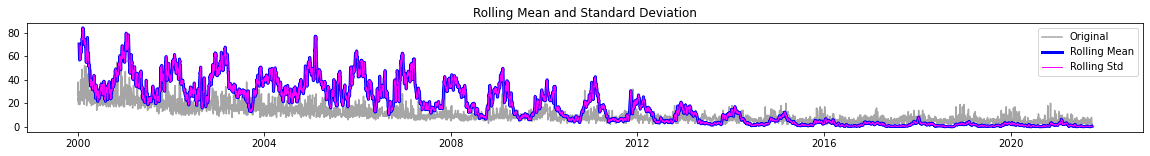

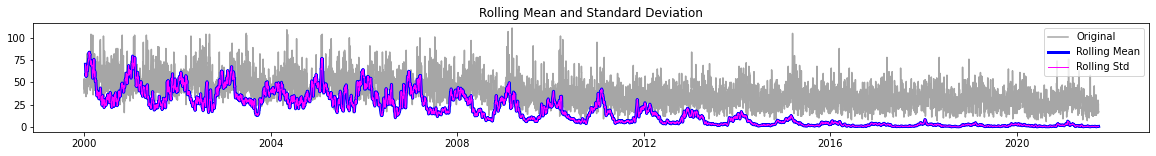

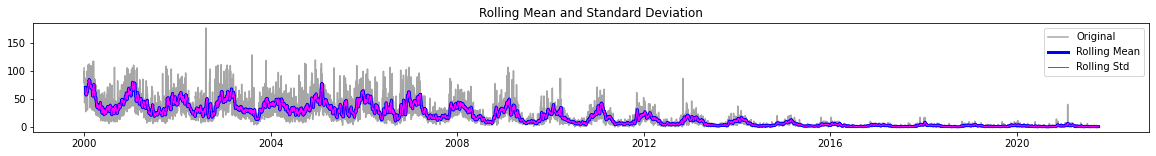

In [82]:
# Determine rolling statistics with a window of 12 months
for df in dflist:
    rmean = df.rolling(window=12, center=False).mean()
    rstd = df.rolling(window=12, center=False).mean()

# Plot rolling statistics against original
for df in dflist:
    fig = plt.figure(figsize=(20,2))
    plt.plot(df, color='#a6a6a6', label='Original')
    plt.plot(rmean, color='blue', linewidth=3, label='Rolling Mean')
    plt.plot(rstd, color='magenta', linewidth=1, label='Rolling Std')
    plt.title('Rolling Mean & Standard Deviation')
    plt.legend();

In [117]:
# Function to check stationarity
def stationarity_check(ts, name):
    """
    Check stationarity of time series with rolling statistics and Dickey-Fuller test.
    """
    rmean = ts.rolling(window=12, center=False).mean()
    rstd = ts.rolling(window=12, center=False).std()
    dftest = adfuller(ts.iloc[:,0])
    
    # Plot rolling statistics against original
    fig = plt.figure(figsize=(20,4))
    plt.plot(ts, color='gray', label='Original')
    plt.plot(rmean, color='blue', label='Rolling Mean')
    plt.plot(rstd, color='magenta', label='Rolling Std')
    plt.title(f'Rolling Mean & Standard Deviation ({name})')
    plt.legend(loc='best')
    plt.show(block=False)
    
    # Print Dickey-Fuller test results
    print('Results of Dickey-Fuller Test: \n')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 
                                             '# of Lags Used', '# of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    return None

In [113]:
dfliststr = ['O3', 'CO', 'NO2', 'SO2']

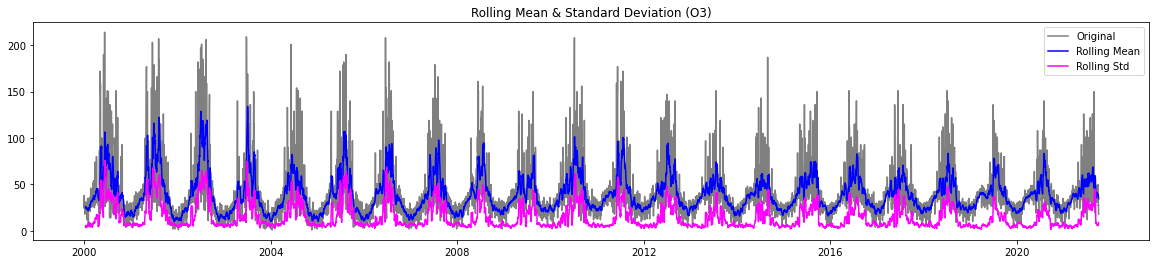

Results of Dickey-Fuller Test: 

Test Statistic           -6.420012e+00
p-value                   1.801269e-08
# of Lags Used            2.900000e+01
# of Observations Used    7.914000e+03
Critical Value (1%)      -3.431177e+00
Critical Value (5%)      -2.861905e+00
Critical Value (10%)     -2.566964e+00
dtype: float64


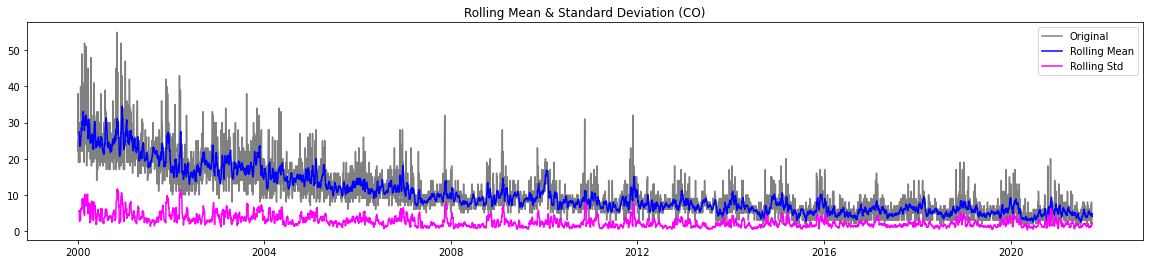

Results of Dickey-Fuller Test: 

Test Statistic              -3.077750
p-value                      0.028244
# of Lags Used              36.000000
# of Observations Used    7908.000000
Critical Value (1%)         -3.431177
Critical Value (5%)         -2.861906
Critical Value (10%)        -2.566965
dtype: float64


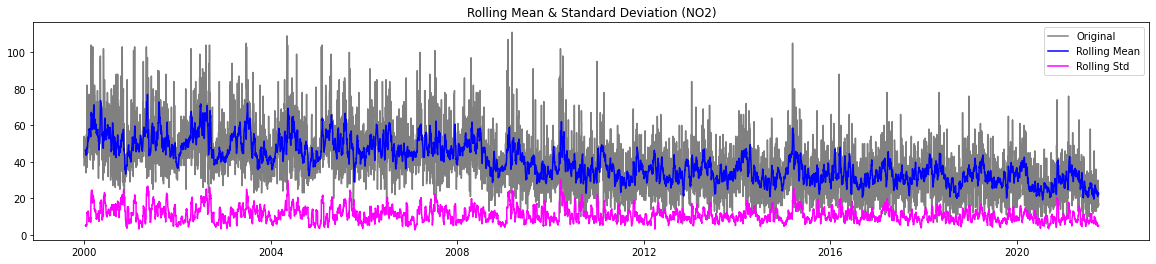

Results of Dickey-Fuller Test: 

Test Statistic              -4.521453
p-value                      0.000180
# of Lags Used              34.000000
# of Observations Used    7909.000000
Critical Value (1%)         -3.431177
Critical Value (5%)         -2.861906
Critical Value (10%)        -2.566965
dtype: float64


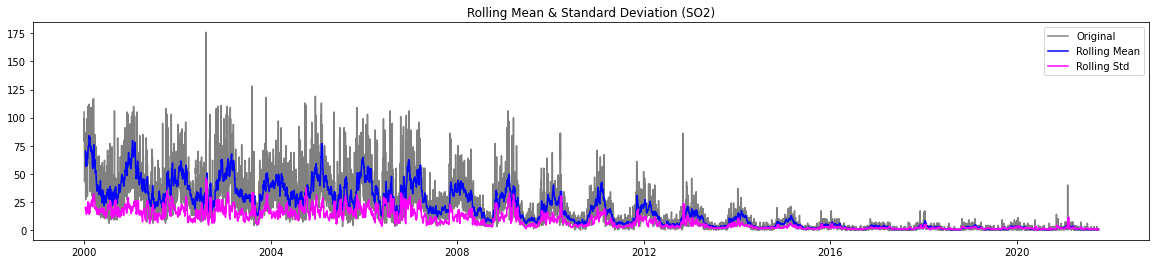

Results of Dickey-Fuller Test: 

Test Statistic              -3.791089
p-value                      0.003000
# of Lags Used              33.000000
# of Observations Used    7910.000000
Critical Value (1%)         -3.431177
Critical Value (5%)         -2.861905
Critical Value (10%)        -2.566965
dtype: float64


In [118]:
i=0
for df in dflist:
    stationarity_check(df, dfliststr[i])
    i+=1

In [146]:
def decomposition_plot(ts):
        '''
        Takes time series dataframe and decomposes it
        in order to observe trend, seasonality, and residuals
        '''
        decomp = seasonal_decompose(ts, period=8, model='additive')
        trend = decomp.trend
        seasonal = decomp.seasonal
        residual = decomp.resid
        plt.figure(figsize=(10,7))
        plt.subplot(511)
        plt.plot(ts, label='Observed', color='red')
        plt.legend(loc='best')
        plt.subplot(512)
        plt.plot(trend, label='Trend', color='blue')
        plt.legend(loc='best')
        plt.subplot(513)
        plt.plot(seasonal, label='Seasonality', color='orange')
        plt.legend(loc='best')
        plt.subplot(514)
        plt.plot(residual, label='Residuals', color='black')
        plt.legend(loc='best')
        plt.tight_layout()
        
        return decomp

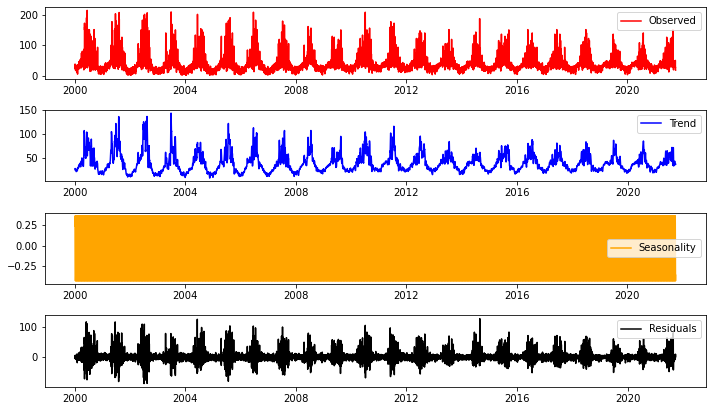

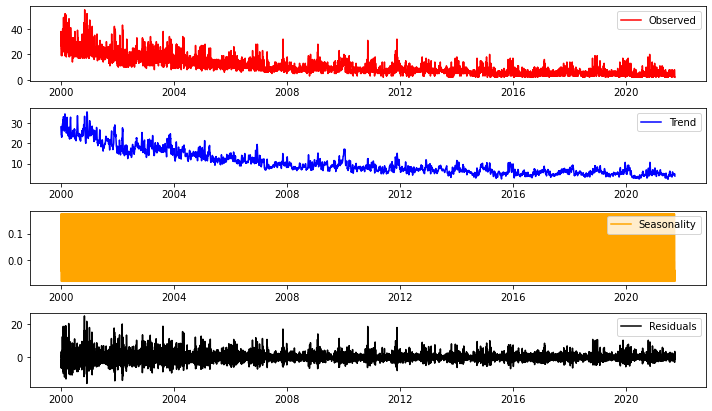

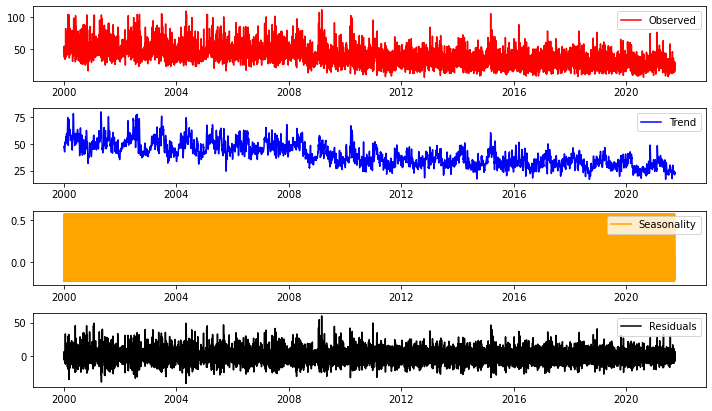

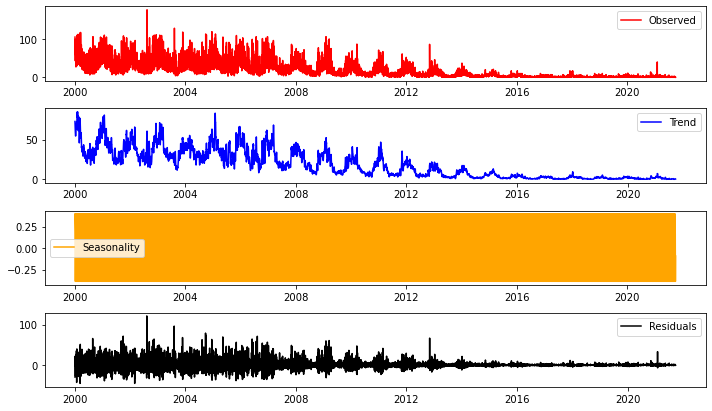

In [147]:
for df in dflist:
    decomposition_plot(df)

In [12]:
def ARMA_model(df, pollutant):

    y = df[f'{pollutant} AQI']
    
    aic_scores = []

    train_size = [len(y),500,250,100,50]

    for p in range(6):
        for q in range(6):
            for size in train_size:
                model = ARIMA(endog = y.tail(size), order =(p,0,q))
                fitmodel = model.fit()
                rmse = np.sqrt(mse(fitmodel))
                aic_scores.append(pd.DataFrame(['ARMA', size, (p,0,q), fitmodel.aic, rmse]).T)
                    
    arma_df = pd.concat(aic_scores, axis = 0)
    arma_df.set_axis(['model type', 'train_size', 'order', 'AIC', 'RMSE'], axis = 1, inplace = True)
    return_df = arma_df.sort_values(['train_size','RMSE'], ascending = [False,True]).reset_index(drop = True)
    
    return return_df

In [13]:
arma = ARMA_model(O3, 'O3')

TypeError: mean_squared_error() missing 1 required positional argument: 'y_pred'

In [18]:
mod_arma = ARMA(O3, order=(1,0), freq='D')
O3_arma = mod_arma.fit()
O3_arma.mse

AttributeError: 'ARMAResults' object has no attribute 'mse'

In [ ]:
# mod_arma = ARMA(O3, order=(1,0), freq='D')
# O3_arma = mod_arma.fit()
# print(O3_arma.summary())

# mod_arma = ARMA(O3, order=(0,1), freq='D')
# O3_arma = mod_arma.fit()
# print(O3_arma.summary())

# mod_arma = ARMA(O3, order=(2,0), freq='D')
# O3_arma = mod_arma.fit()
# print(O3_arma.summary())

# mod_arma = ARMA(O3, order=(0,2), freq='D')
# O3_arma = mod_arma.fit()
# print(O3_arma.summary())

# mod_arma = ARMA(O3, order=(2,1), freq='D')
# O3_arma = mod_arma.fit()
# print(O3_arma.summary())

# mod_arma = ARMA(O3, order=(1,2), freq='D')
# O3_arma = mod_arma.fit()
# print(O3_arma.summary())

# mod_arma = ARMA(O3, order=(2,2), freq='D')
# O3_arma = mod_arma.fit()
# print(O3_arma.summary())

# mod_arima = ARIMA(O3, order=(1,1,1), freq='D')
# O3_arima = mod_arima.fit()
# print(O3_arima.summary())

# mod_sarimax = SARIMAX(O3, order=(1,1,1), freq='D')
# O3_sarimax = mod_sarimax.fit()
# print(O3_sarimax.summary())